In [9]:
!pip install datasets
!pip install TextBlob
import torch
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam ,SGD
from sklearn.feature_extraction.text import TfidfVectorizer
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from textblob import TextBlob, Word
import nltk
nltk.download('wordnet')
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load datasets

In [10]:
train_dataset = load_dataset("surrey-nlp/PLOD-CW", split='train')
test_dataset = load_dataset("surrey-nlp/PLOD-CW", split='test')
validation_dataset = load_dataset("surrey-nlp/PLOD-CW", split='train')

# Data Pre-Processing

In [3]:
def lemmatize_tokens(tokens):
    #Lemmatize list of tokens
    lemmatized_tokens = []
    for token in tokens:
        word = Word(token)
        lemmatized_token = word.lemmatize()
        lemmatized_tokens.append(lemmatized_token)
    return lemmatized_tokens

def apply_lemmatization_to_dataset(dataset):
    #Add a new field for lemmatized tokens
    lemmatized_texts = []
    for example in dataset:
        lemmatized_text = lemmatize_tokens(example['tokens'])
        lemmatized_texts.append(lemmatized_text)
    dataset = dataset.add_column("lemmatized_tokens", lemmatized_texts)
    return dataset

# Applying lemmatization to both train and test datasets
train_dataset = apply_lemmatization_to_dataset(train_dataset)
test_dataset = apply_lemmatization_to_dataset(test_dataset)
validation_dataset = apply_lemmatization_to_dataset(validation_dataset)

# Create a corpus from tokens


In [4]:
train_texts=train_dataset['lemmatized_tokens']
test_texts=test_dataset['lemmatized_tokens']
validation_texts=test_dataset['lemmatized_tokens']

# Initialize TF-IDF Vectorizer


In [5]:
train_texts_flat = [label for sublist in train_texts for label in sublist]
test_texts_flat = [label for sublist in test_texts for label in sublist]
validation_texts_flat = [label for sublist in validation_texts for label in sublist]

vectorizer = TfidfVectorizer(max_features=3000)  # Adjust max_features
vectorizer.fit(train_texts_flat + test_texts_flat)  # to ensure vocabulary coverage


TfidfVectorizer(max_features=3000)

# Transform datasets to TF-IDF vectors


In [6]:
train_vectors = vectorizer.transform(train_texts_flat).toarray()
test_vectors = vectorizer.transform(test_texts_flat).toarray()
validation_vectors = vectorizer.transform(validation_texts_flat).toarray()

# label Encoding


In [7]:
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform([tag for example in train_dataset["ner_tags"] for tag in example])
test_labels = label_encoder.transform([tag for example in test_dataset["ner_tags"] for tag in example])
validation_labels = label_encoder.fit_transform([tag for example in validation_dataset["ner_tags"] for tag in example])

class TFIDFDataset(Dataset):
    def __init__(self, X, labels):
        self.X = X
        self.labels = labels

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.labels[idx]

# Creating dataset instances


In [8]:
train_data = TFIDFDataset(train_vectors,train_labels)
test_data = TFIDFDataset(test_vectors,test_labels)
validation_data = TFIDFDataset(validation_vectors,validation_labels)

print(train_data)
print(test_data)
print(validation_data)
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BiLSTMModel, self).__init__()
        self.Bilstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input_data):
        # Reshape input_data to have sequence length of 1
        input_data = input_data.unsqueeze(1)
        Bilstm_output,(last_hidden_state, last_cell_state) = self.Bilstm(input_data)
        # Extract the last hidden state
        last_hidden_state = last_hidden_state.squeeze(0)  # squeeze sequence length dimension
        return self.fc(last_hidden_state)

# train the model


<ipython-input-25-55b56613cbca>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  texts = torch.tensor(texts, dtype=torch.float32)  # Ensure correct type
<ipython-input-25-55b56613cbca>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.int64)
<ipython-input-25-55b56613cbca>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  texts = torch.tensor(texts, dtype=torch.float32)
<ipython-input-25-55b56613cbca>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Epoch: 0, Test Accuracy: 0.8584
Epoch: 1, Test Accuracy: 0.8614
Epoch: 2, Test Accuracy: 0.8634
Epoch: 3, Test Accuracy: 0.8672
Epoch: 4, Test Accuracy: 0.8616
Epoch: 5, Test Accuracy: 0.8628
Epoch: 6, Test Accuracy: 0.8630
Epoch: 7, Test Accuracy: 0.8618
Epoch: 8, Test Accuracy: 0.8602
Epoch: 9, Test Accuracy: 0.8624
              precision    recall  f1-score   support

        B-AC       0.72      0.26      0.39       270
        B-LF       0.34      0.15      0.21       150
         B-O       0.89      0.97      0.93      4292
        I-LF       0.39      0.19      0.26       288

    accuracy                           0.86      5000
   macro avg       0.59      0.39      0.44      5000
weighted avg       0.83      0.86      0.84      5000



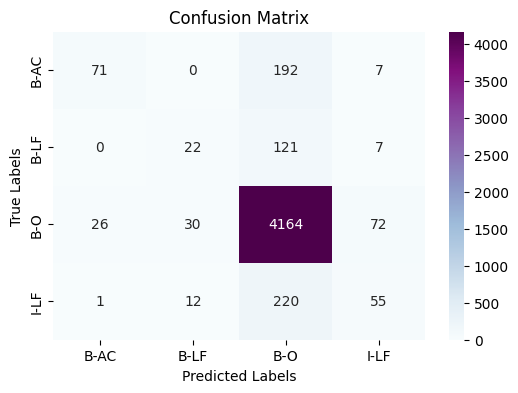

In [25]:
# Update model parameters to match the TF-IDF feature size
from sklearn.metrics import classification_report, accuracy_score

input_size = train_vectors.shape[1]
hidden_size = 100
output_size = len(label_encoder.classes_)

model = BiLSTMModel(input_size, hidden_size, output_size)

def train_model(model, train_data, test_data, validation_data):
    train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=16, shuffle=False)
    validation_loader = DataLoader(validation_data, batch_size=64, shuffle=False)


    optimizer = Adam(model.parameters(), lr=0.0006)
    #optimizer = SGD(model.parameters(), lr=0.006)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(10):  # Training loop
        model.train()
        for texts, labels in train_loader:
            texts = torch.tensor(texts, dtype=torch.float32)  # Ensure correct type
            labels = torch.tensor(labels, dtype=torch.int64)
            optimizer.zero_grad()
            predictions = model(texts)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
          for texts, labels in test_loader:
            texts = torch.tensor(texts, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)
            predicted_labels = model(texts)
            all_preds.extend(predicted_labels.argmax(1).tolist())
            all_labels.extend(labels.tolist())

        model.eval()
        all_preds = []
        all_labels = []
        total_acc, total_count = 0, 0
        with torch.no_grad():
          for texts, labels in test_loader:
            texts = torch.tensor(texts, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)
            predicted_labels = model(texts)
            all_preds.extend(predicted_labels.argmax(1).tolist())
            all_labels.extend(labels.tolist())
            total_acc += (predicted_labels.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

        print(f'Epoch: {epoch}, Test Accuracy: {(total_acc / total_count):.4f}')

# train_model(model, train_data, test_data)

    # Calculate and print classification report
    target_names = label_encoder.classes_.tolist()
    print(classification_report(all_labels, all_preds, target_names=target_names, labels=range(len(target_names))))
    plot_confusion_matrix(all_labels, all_preds,target_names)

def plot_confusion_matrix(all_labels,all_preds,target_names):
    target_names = label_encoder.classes_.tolist()
    cm = confusion_matrix(all_labels, all_preds, labels=range(len(target_names)))
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="BuPu", xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

train_model(model, train_data, test_data, validation_data)